In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
input_dim=7
cond_dim=3
latent_dim=5
n_hidden=5
hidden_size=16
batch_size=10000

We have derived that

$\tilde{A_i} = (G^T\Sigma_i^{-1}G)^{-1}G^T\Sigma_i^{-1}\vec{R}_{i,obs}.$

$
\rm
Cov(\tilde{A_i},\tilde{A_i}) = B\ Cov(R_{i,obs},R_{i,obs})\ B^T = B\ \Sigma_i\ B^T,
$
where $B = (G^T\Sigma_i^{-1}G)^{-1}G^T\Sigma_i^{-1}$.

$
Cov(\tilde{A_i},\tilde{A_i}) = (G^T\Sigma_i^{-1}G)^{-1}G^T\Sigma_i^{-1}\Sigma_i\Sigma_i^{-1}G(G^T\Sigma_i^{-1}G)^{-1}=(G^T\Sigma_i^{-1}G)^{-1}.
$

=>We should provide different cov-matrices to different stars
$
Cov(\tilde{A_i},\tilde{A_i})^{-1} = (G^T\Sigma_i^{-1}G)
$


In [2]:
A = np.load('A_real.npy').T

A_mean = np.mean(A,axis=0)

A_std = np.std(A,axis=0)/5.# std is larger due to extreme values

A = (A-A_mean)/A_std
print(A_std)


[2.4047331  0.83711309 1.96299641 1.15170003 0.94973234 0.94772497
 0.57143773]


If some stars have more than 6 bands missing, this will still set constraints on G, but is not helpful to show the pattern of A, and will ruin the std.

We should have removed those 'bad A_parameters'.

In [3]:
'''safe = np.where(np.abs(A[:,0])<1.0)[0]
for i in range(7):
    x = A[:,i]
    y = np.where(np.abs(A[:,i])<1.0)[0]
    safe = np.union1d(safe,y)
print(safe)'''
safe = np.load('safe_A.npy')[0]
safe

array([      2,       3,       4, ..., 2888356, 2888357, 2888360])

In [4]:
len(safe)/len(A)

0.8822249019426588

This is a naive bar (30.01.2022 version), we throw away all of the large A, which only take up less than 4%

In [5]:
import h5py as hp
f = hp.File('/home/seanzhang/0_mpia/code/apogee_lamost_galah_data.h5','r')
d = f['io_data']
param = d['atm_param_p']
f.close()

In [6]:
Cov_A_1 = np.load('Cov_A_1_normal.npy')/25.# normalized by mean value of A, and devided by 25 since A is timed 5

In [7]:
A = A[safe]
Cov_A_1 = Cov_A_1[safe]
param = param[safe]

In [8]:
def sum_chi2(y_true,y_pred):
    #loss function, summation of chi2 per DOF
    return tf.reduce_sum(y_pred)/batch_size/input_dim

In [9]:
class ConditionalAutoencoder(keras.Model):
    '''
    Basically the same structure in your toy model
    
    '''
    def __init__(self, input_dim, cond_dim, latent_dim,
               n_hidden, hidden_size, l2=1e-4):
            super(ConditionalAutoencoder, self).__init__()

            hidden_dim = [hidden_size for i in range(n_hidden)]
            print('hidden dimensions:', hidden_dim)

            x = keras.layers.Input(input_dim, name='x')
            z = keras.layers.Input(cond_dim, name='z')

            layer = keras.layers.Concatenate(
                axis=1, name='xz')([x, z])
            for k,d in enumerate(hidden_dim):
                layer = keras.layers.Dense(
                d, activation='tanh',
                kernel_regularizer=keras.regularizers.l2(l2),
                name=f'hidden_{k+1}'
                )(layer)
            layer = keras.layers.Dense(
                latent_dim,
                activation='tanh',
                name='y'
                )(layer)         
            self.encoder = tf.keras.Model(
                inputs=[x,z],
                outputs=layer,
                name='encoder'
                )

            y = keras.layers.Input(latent_dim, name='y')
            z = keras.layers.Input(cond_dim, name='z')
            
            layer = keras.layers.Concatenate(
                axis=1, name='yz'
                )([y, z])
            for k,d in enumerate(hidden_dim):
                layer = keras.layers.Dense(
                    d, activation='tanh',
                    kernel_regularizer=keras.regularizers.l2(l2),#version problem? L2(with Cap L) will cause errors.
                    name=f'hidden_{k+1}'
                    )(layer)
            layer = keras.layers.Dense(
                input_dim,
                name='x'
                )(layer)            
            
            self.decoder = tf.keras.Model(
            inputs=[y,z],
            outputs=layer,
            name='decoder'
            )
            
    def call(self, xzc):
            x,z,c_1 = xzc
            y = self.encode(x, z)
            xp = self.decode(y, z)
            dx = x-xp
            chi2 = tf.einsum('ij,ijk,ik->i',dx,c_1,dx)
            return chi2# output chi2 to generate loss function
        
    def encode(self, x, z):
            return self.encoder([x, z])
    def decode(self, y, z):
            return self.decoder([y, z])




In [10]:
model = ConditionalAutoencoder(input_dim=7, cond_dim=3, latent_dim=3,
               n_hidden=5, hidden_size=16, l2=1e-4)
model.build([(None,input_dim),(None,cond_dim),(None,input_dim,input_dim)])
model.summary()

hidden dimensions: [16, 16, 16, 16, 16]
Model: "conditional_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Functional)         (None, 3)                 1315      
_________________________________________________________________
decoder (Functional)         (None, 7)                 1319      
Total params: 2,634
Trainable params: 2,634
Non-trainable params: 0
_________________________________________________________________


In [11]:
opt = keras.optimizers.Adam(learning_rate=0.01)

In [12]:
model.compile(optimizer=opt, loss=sum_chi2)

In [13]:
A.shape

(2548184, 7)

In [14]:
param.shape

(2548184, 3)

In [15]:
Cov_A_1.shape

(2548184, 7, 7)

In [16]:
x_encoded_history = [model.encode(A[-1024:], param[-1024:]).numpy()]

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=32, verbose=1,
        mode='min', min_delta=1e-4, cooldown=0, min_lr=0
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=1e-5, patience=64, verbose=1,
        mode='min', baseline=None, restore_best_weights=False
    ),
    keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch, logs: x_encoded_history.append(
            model.encode(A[-1024:], param[-1024:]).numpy()
        )
    )
]

fit_history = model.fit(
    (A,param,Cov_A_1), np.zeros((A.shape[0],1)),
    batch_size=batch_size,
    epochs=1024,
    validation_split=1/4,
    callbacks=callbacks
)

Epoch 1/1024
192/192 [==============================] - 2s 5ms/step - loss: 24.0625 - val_loss: 2.7910
Epoch 2/1024
192/192 [==============================] - 1s 3ms/step - loss: 3.0745 - val_loss: 2.4126
Epoch 3/1024
192/192 [==============================] - 1s 3ms/step - loss: 2.7570 - val_loss: 2.1190
Epoch 4/1024
192/192 [==============================] - 1s 3ms/step - loss: 2.4118 - val_loss: 2.1888
Epoch 5/1024
192/192 [==============================] - 1s 3ms/step - loss: 2.3311 - val_loss: 2.2001
Epoch 6/1024
192/192 [==============================] - 1s 3ms/step - loss: 2.5115 - val_loss: 2.1349
Epoch 7/1024
192/192 [==============================] - 1s 3ms/step - loss: 2.3423 - val_loss: 2.0545
Epoch 8/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.9852 - val_loss: 2.0971
Epoch 9/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.9852 - val_loss: 2.3965
Epoch 10/1024
192/192 [==============================] - 1s 3ms/step - loss: 2.19

192/192 [==============================] - 1s 3ms/step - loss: 1.4936 - val_loss: 1.4218
Epoch 81/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.4631 - val_loss: 1.4804
Epoch 82/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.3962 - val_loss: 1.6108
Epoch 83/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.4211 - val_loss: 1.4487
Epoch 84/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.4026 - val_loss: 1.5678
Epoch 85/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.5177 - val_loss: 1.4705
Epoch 86/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.4450 - val_loss: 1.6257
Epoch 87/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.6240 - val_loss: 1.4005
Epoch 88/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.4425 - val_loss: 1.3901
Epoch 89/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.4062 - v

192/192 [==============================] - 1s 3ms/step - loss: 1.3162 - val_loss: 1.3263
Epoch 159/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.3004 - val_loss: 1.3017
Epoch 160/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.2829 - val_loss: 1.7473
Epoch 161/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.6399 - val_loss: 1.3329
Epoch 162/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.2923 - val_loss: 1.3377
Epoch 163/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.3125 - val_loss: 1.3902
Epoch 164/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.3508 - val_loss: 1.3192
Epoch 165/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.3747 - val_loss: 1.5011
Epoch 166/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.3661 - val_loss: 1.3029
Epoch 167/1024
192/192 [==============================] - 1s 3ms/step - loss: 1

192/192 [==============================] - 1s 3ms/step - loss: 1.2331 - val_loss: 1.3182
Epoch 237/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.2674 - val_loss: 1.3696
Epoch 238/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.2963 - val_loss: 1.2778
Epoch 239/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.2350 - val_loss: 1.2973
Epoch 240/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.2392 - val_loss: 1.2921
Epoch 241/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.2590 - val_loss: 1.2743
Epoch 242/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.2091 - val_loss: 1.2569
Epoch 243/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.2259 - val_loss: 1.3661
Epoch 244/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.3168 - val_loss: 1.2586
Epoch 245/1024
192/192 [==============================] - 1s 3ms/step - loss: 1

192/192 [==============================] - 1s 3ms/step - loss: 1.2294 - val_loss: 1.2348
Epoch 314/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1643 - val_loss: 1.2314
Epoch 315/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1380 - val_loss: 1.2354
Epoch 316/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.2172 - val_loss: 1.2375
Epoch 317/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.2449 - val_loss: 1.2290
Epoch 318/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1905 - val_loss: 1.2416
Epoch 319/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.2209 - val_loss: 1.2367
Epoch 320/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.2387 - val_loss: 1.2406
Epoch 321/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.2300 - val_loss: 1.2335
Epoch 322/1024
192/192 [==============================] - 1s 3ms/step - loss: 1

192/192 [==============================] - 1s 3ms/step - loss: 1.1506 - val_loss: 1.2220
Epoch 392/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.2419 - val_loss: 1.2287
Epoch 393/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1989 - val_loss: 1.2302
Epoch 394/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.2135 - val_loss: 1.2183
Epoch 395/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1587 - val_loss: 1.2198
Epoch 396/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1545 - val_loss: 1.2209
Epoch 397/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1778 - val_loss: 1.2224
Epoch 398/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1849 - val_loss: 1.2219
Epoch 399/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.2018 - val_loss: 1.2247
Epoch 400/1024
192/192 [==============================] - 1s 3ms/step - loss: 1

Epoch 470/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0816 - val_loss: 1.1521
Epoch 471/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1446 - val_loss: 1.1541
Epoch 472/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1298 - val_loss: 1.1469
Epoch 473/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0974 - val_loss: 1.1438
Epoch 474/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1425 - val_loss: 1.1411
Epoch 475/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1160 - val_loss: 1.1418
Epoch 476/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0886 - val_loss: 1.1383
Epoch 477/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1212 - val_loss: 1.1374
Epoch 478/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1541 - val_loss: 1.1476
Epoch 479/1024
192/192 [==============================] - 1s 3ms

Epoch 549/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0874 - val_loss: 1.1208
Epoch 550/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1215 - val_loss: 1.1220
Epoch 551/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0762 - val_loss: 1.1527
Epoch 552/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1143 - val_loss: 1.1303
Epoch 553/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0832 - val_loss: 1.1230
Epoch 554/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0923 - val_loss: 1.1227
Epoch 555/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0549 - val_loss: 1.1230
Epoch 556/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1829 - val_loss: 1.1167
Epoch 557/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0708 - val_loss: 1.1229
Epoch 558/1024
192/192 [==============================] - 1s 3ms

Epoch 628/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0717 - val_loss: 1.1158
Epoch 629/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1254 - val_loss: 1.1172
Epoch 630/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0898 - val_loss: 1.1701
Epoch 631/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1342 - val_loss: 1.1199
Epoch 632/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1081 - val_loss: 1.1109
Epoch 633/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1073 - val_loss: 1.1133
Epoch 634/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1116 - val_loss: 1.1136
Epoch 635/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0901 - val_loss: 1.1099
Epoch 636/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1296 - val_loss: 1.1119
Epoch 637/1024
192/192 [==============================] - 1s 3ms

Epoch 707/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1192 - val_loss: 1.0995
Epoch 708/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0683 - val_loss: 1.1009
Epoch 709/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0895 - val_loss: 1.1062
Epoch 710/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0891 - val_loss: 1.1102
Epoch 711/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0898 - val_loss: 1.0999
Epoch 712/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0861 - val_loss: 1.1098
Epoch 713/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0363 - val_loss: 1.0981
Epoch 714/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0868 - val_loss: 1.1073
Epoch 715/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0842 - val_loss: 1.1022
Epoch 716/1024
192/192 [==============================] - 1s 3ms

Epoch 786/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0383 - val_loss: 1.0956
Epoch 787/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0786 - val_loss: 1.0948
Epoch 788/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0547 - val_loss: 1.1056
Epoch 789/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0800 - val_loss: 1.0981
Epoch 790/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0962 - val_loss: 1.1014
Epoch 791/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0310 - val_loss: 1.1126
Epoch 792/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1033 - val_loss: 1.0982
Epoch 793/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0479 - val_loss: 1.1687
Epoch 794/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0870 - val_loss: 1.1144
Epoch 795/1024
192/192 [==============================] - 1s 3ms

Epoch 864/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0425 - val_loss: 1.0977
Epoch 865/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0771 - val_loss: 1.0932
Epoch 866/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0874 - val_loss: 1.0907
Epoch 867/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0761 - val_loss: 1.0907
Epoch 868/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0375 - val_loss: 1.0952
Epoch 869/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0432 - val_loss: 1.0928
Epoch 870/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0936 - val_loss: 1.0913
Epoch 871/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0781 - val_loss: 1.0923
Epoch 872/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1032 - val_loss: 1.0919
Epoch 873/1024
192/192 [==============================] - 1s 3ms

Epoch 943/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0559 - val_loss: 1.0910
Epoch 944/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0734 - val_loss: 1.0931
Epoch 945/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0664 - val_loss: 1.0902
Epoch 946/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.1160 - val_loss: 1.0967
Epoch 947/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0989 - val_loss: 1.0913

Epoch 00947: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.
Epoch 948/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0730 - val_loss: 1.0886
Epoch 949/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0637 - val_loss: 1.0902
Epoch 950/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0701 - val_loss: 1.0921
Epoch 951/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0502 - 

Epoch 1021/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0889 - val_loss: 1.0873
Epoch 1022/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0237 - val_loss: 1.0896
Epoch 1023/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0766 - val_loss: 1.0870
Epoch 1024/1024
192/192 [==============================] - 1s 3ms/step - loss: 1.0235 - val_loss: 1.0899


In [17]:
z = model.encoder((A,param))
xp = model.decoder((z,param))

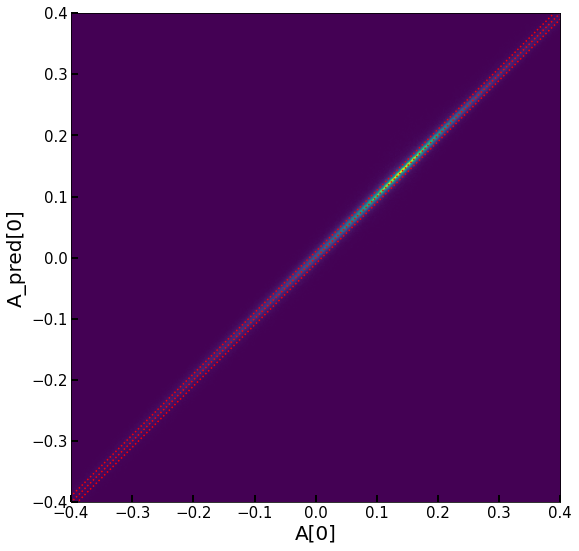

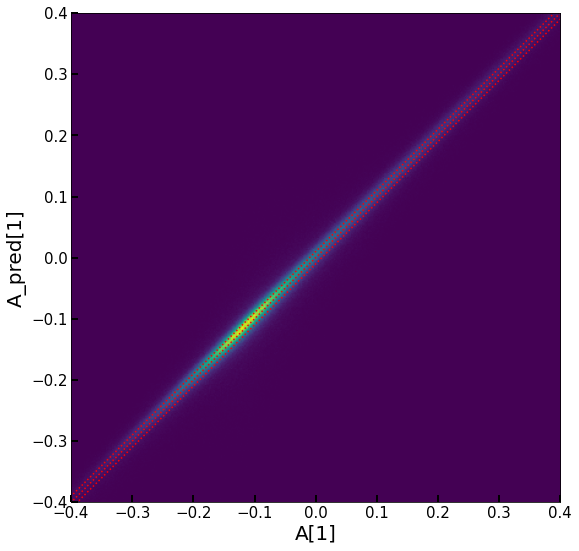

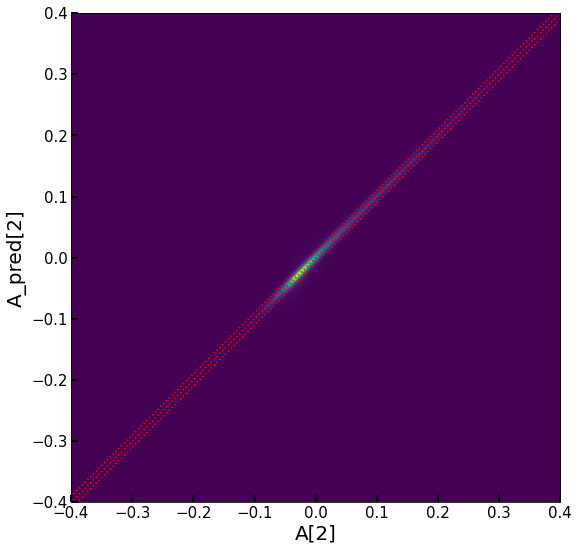

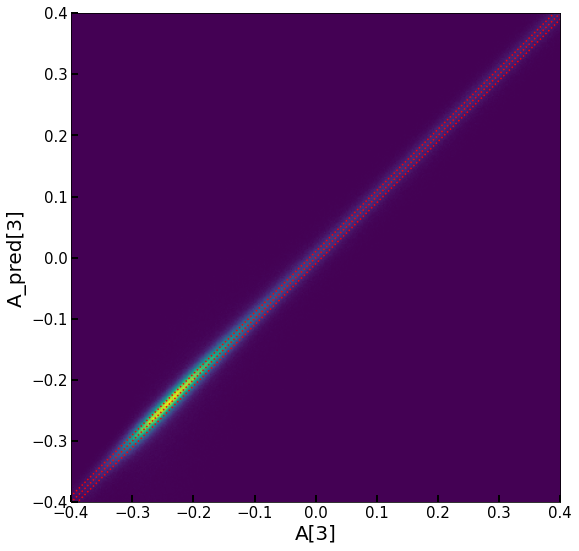

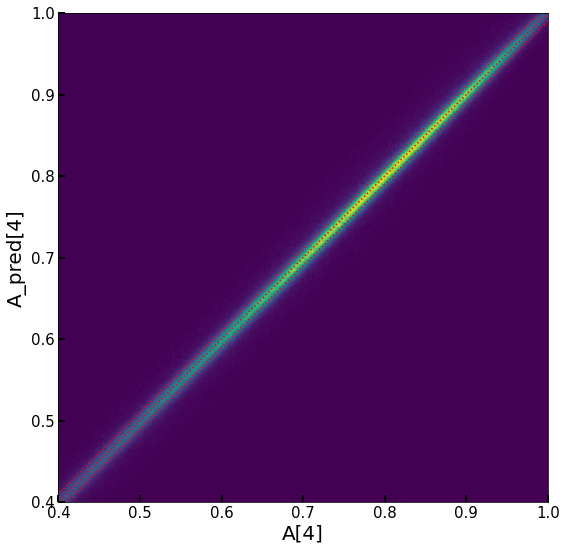

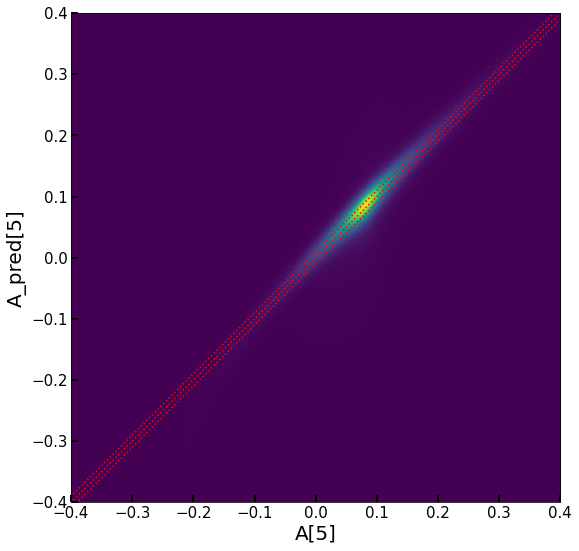

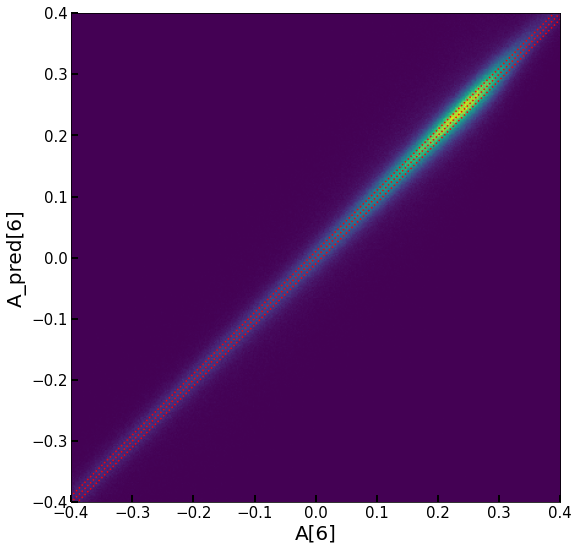

In [18]:
for i in range(7):
    plt.figure(figsize=(9,9))
    x = A[:,i]
    y = xp[:,i]
    range_a = 10.
    range_show = 0.4
    nbins= 10000

    xbins=np.linspace(-range_a,range_a,nbins)
    
    hist2d,xbins,ybins = np.histogram2d(x,y,weights=Cov_A_1[:,i,i],bins=xbins)
    plt.imshow(hist2d[::-1],extent=(-range_a,range_a,-range_a,range_a))
    
    
    

    plt.tick_params(axis='both',labelsize=15, direction = 'in',width=2,length=7,which='major')
    plt.plot(np.linspace(-range_a,range_a,nbins),np.linspace(-range_a,range_a,nbins),':',color='r')
    plt.plot(np.linspace(-range_a,range_a,nbins),np.linspace(-range_a,range_a,nbins)+0.01,':',color='r')
    plt.plot(np.linspace(-range_a,range_a,nbins),np.linspace(-range_a,range_a,nbins)-0.01,':',color='r')
    plt.xlabel('A[%i]'%i,size=20)
    plt.ylabel('A_pred[%i]'%i,size=20)
    

    if(i==4):
        plt.ylim([0.4,1.0])
        plt.xlim([0.4,1.0])
    else:
        plt.ylim([-range_show,range_show])
        plt.xlim([-range_show,range_show])
    plt.show()    
     

In [19]:
z = model.encoder((A,param)).numpy()

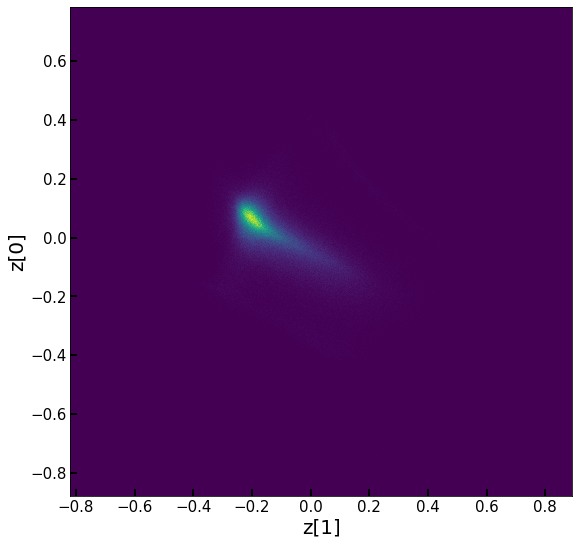

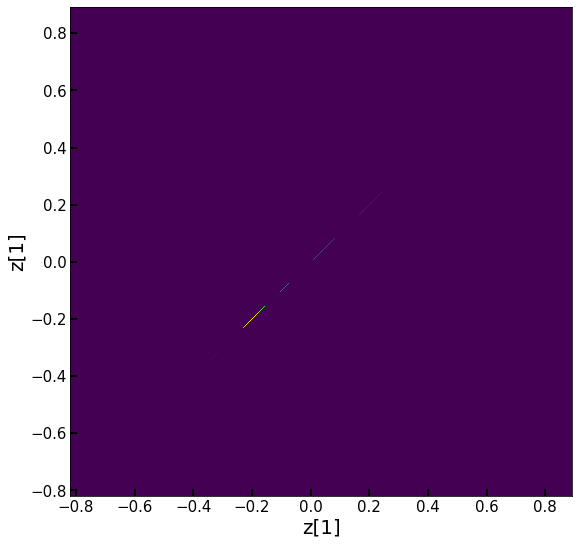

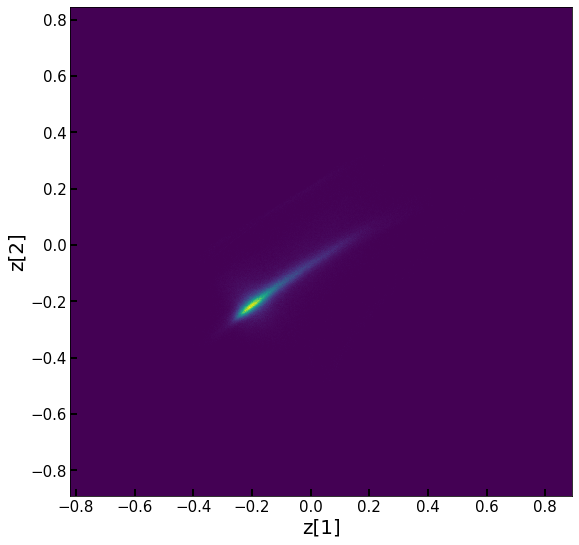

In [20]:
for i in range(3):
    plt.figure(figsize=(9,9))
    plt.hist2d(z[:,1],z[:,i],bins=1000,density=True)
    plt.xlabel('z[1]',size=20)
    plt.ylabel('z[%i]'%i,size=20)
    plt.tick_params(axis='both',labelsize=15, direction = 'in',width=2,length=7,which='major')
    plt.show()

There are sharp cuts (like z[0] vs z[1]) and also discontinued pattern (like z[2] vs z[1])

=> This may suggest that there are cases like 0->2$\pi$